In [133]:
#The libraries we are going to use are PySerial and Time
# PySerial is encapsulates the access for the serial port.
import serial
import time
import numpy as np
import os
import matplotlib.pyplot as plt

In [134]:
# Opening a Serial port

# - The port is immediately opened on object creation, when a port is given. It is not opened when
# port is None and a successive call to open() is required. port is a device name: depending on 
# operating system. e.g. /dev/ttyUSB0 on GNU/Linux or COM3 on Windows.
# - The parameter baudrate can be one of the standard values:  50, 75, 110, 134, 150, 200, 300, 600, 1200,
# 1800, 2400, 4800, 9600, 19200, 38400, 57600, 115200. These are well supported on all platforms.
# - Standard values above 115200, such as:  230400, 460800, 500000, 576000, 921600, 1000000, 1152000,
# 1500000, 2000000, 2500000, 3000000, 3500000, 4000000 also work on many platforms and devices.
# Non-standard values are also supported on some platforms (GNU/Linux, MAC OSX >= Tiger, Windows).
# - Possible values for the parameter timeout which controls the behavior of read():
# .. timeout = None: wait forever until requested number of bytes are received
# .. timeout = 0:  non-blocking mode, return immediately in any case, returning zero or more, up to
# the requested number of bytes
# .. timeout = x:  set timeout to x seconds (float allowed) returns immediately when the requested
# number of bytes are available, otherwise wait until the timeout expires and return all bytes that were
# received until then.
DEMOQE_read = serial.Serial('/dev/ttyUSB1',115200,timeout=1);
print(DEMOQE_read.isOpen())

True


In [135]:
# VARIABLES para almacenar los valores de los sensores en el tiempo
digital_1 = []
digital_2 = []
analogico_1 = []
analogico_1.append(0)
analogico_2 = []
# Constantes de manipulacion para el main
flag_first_run = 0
flag_trama_len_cst = 0
list_pos_trama = []
i = 0
j = 0
data_list = []
#os.remove("Generator_data.txt")
file = open("Generator_data.txt","w")
file.write("0")
file.close()

In [136]:
#Hex to binary
def dec_to_bin(dec):
    dec_str = str(int(dec))
    cod_bin = bin(int(dec_str))
    return cod_bin

In [137]:
#Binary to decimal
def bin_to_dec(bina):
    cod_dec = int(str(bina),2)
    return cod_dec

In [138]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 D1 D2 A11 A10 A9 A8 A7
def decode_channel1_one(number):
    #decode Channel one
    part_one_bin = dec_to_bin(number)
    len_bit_number = len(part_one_bin) -2
    diferencia = 8 - len_bit_number
    cero_faltante = "0"*diferencia
    part_one_bin_comp = (cero_faltante + str(part_one_bin[2:]))
    digital_one = part_one_bin_comp[1]
    digital_two = part_one_bin_comp[2]
    analogic_most_significant = part_one_bin_comp[3:]
    return digital_one,digital_two,str(analogic_most_significant)

In [139]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 A6 A5 A4 A3 A2 A1 A0
def decode_channel12_two(number):
    #decode channe one and two for less significant bits
    part_one_bin = dec_to_bin(number)
    len_bit_number = len(part_one_bin) -2
    diferencia = 8 - len_bit_number
    cero_faltante = "0"*diferencia
    part_one_bin_comp = (cero_faltante + str(part_one_bin[2:]))
    analogic_less_significant = part_one_bin_comp[1:]
    return str(analogic_less_significant)

In [140]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 0 0 A11 A10 A9 A8 A7
def decode_channel2_one(number):
    # decode channel two for most significant bits
    part_one_bin = dec_to_bin(number)
    len_bit_number = len(part_one_bin) -2
    diferencia = 8 - len_bit_number
    cero_faltante = "0"*diferencia
    part_one_bin_comp = (cero_faltante + str(part_one_bin[2:]))
    analogic_most_significant = part_one_bin_comp[3:]
    
    return str(analogic_most_significant)

In [141]:
# We need to concatened the entirely analogic information.
def concatenation(string1,string2):
    return bin_to_dec(int(string1 + str(string2)))

In [142]:
flag_first_run = 0
flag_encabezado = 0
while True:
    file = open("Generator_data.txt","a")
    while (DEMOQE_read.inWaiting()==0):
        pass
            # Se recibiran 5 bytes por el puerto serial segun el protocolo
            # time.sleep(0.000001)
    
    DEMOQE_read.flush()
    data_input_2 = DEMOQE_read.read(5)
    data_list.append(data_input_2)
    
    posic_data_input = len(data_list)-1
    #data_input = data_list[posic_data_input]
    data_input = data_input_2
    
    #Codigo 
    flag_trama_len_cst = 0
    list_pos_trama = []
    for datop in data_input:
        if datop==245:
            flag_encabezado+=1
    if flag_encabezado>1:
        flag_encabezado=0
        continue
    enc_posi = data_input.find(245)
    
    # Chequeo de encabezado en la primera casilla
    if enc_posi==0:
        flag_first_run=0
    # Longitud de la trama
    trama_length = len(data_input)
    if trama_length!=5:
        pass
    posiciones = trama_length - enc_posi -1
    # Chequeo de encabezado en su ultima casilla
    if posiciones==0:
        flag_first_run=1
    # Entrando formato de la primera corrida
    if (flag_first_run==0):
        for pos in range(posiciones):
            list_pos_trama.append(enc_posi +pos+1)
        for pos_dato_trama in list_pos_trama:
            if (pos_dato_trama == enc_posi +1):
                digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                digital_1.append(digital_one)
                digital_2.append(digital_two)
                auxiliar = analogic_m_b
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi + 2):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_1.append(concatenation(auxiliar,analogic_l_b))
                flag_trama_len_cst += 1
                if enc_posi==2:
                    flag_trama_len_cst=0
                    flag_first_run=1
            elif (pos_dato_trama == enc_posi + 3):
                
                analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                auxiliar2 = analogic_m_b
                flag_trama_len_cst += 1
                if enc_posi==1:
                    flag_trama_len_cst=0
                    flag_first_run=1
                    analogic_l_b = decode_channel12_two(data_input[0])
                    analogico_2.append(concatenation(auxiliar2,analogic_l_b))
            elif (pos_dato_trama == enc_posi + 4):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_2.append(concatenation(auxiliar2,analogic_l_b))
                flag_trama_len_cst += 1
            else:
                flag_first_run=1
                if (flag_trama_len_cst == 4):
                    flag_trama_len_cst = 0
                    flag_first_run=0
    else:
        posiciones = trama_length - enc_posi -1
        # Verificar que llegaron los dos canales completos
        for pos_dato_trama in range(enc_posi):
            if (pos_dato_trama == enc_posi -1):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_2.append(concatenation(auxiliar2,analogic_l_b))
                flag_trama_len_cst += 1
                if enc_posi==1:
                    # Agregando la posicion 3 antes de salir
                    digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[2])
                    digital_1.append(digital_one)
                    digital_2.append(digital_two)
                    auxiliar = analogic_m_b
                    # Agregando la ultima posicion antes de salir
                    analogic_l_b = decode_channel12_two(data_input[3])
                    analogico_1.append(concatenation(auxiliar,analogic_l_b))
                    analogic_m_b = decode_channel2_one(data_input[4])
                    auxiliar2 = analogic_m_b
                    flag_first_run=1
                if enc_posi==2:
                    # Agregando la posicion 3 antes de salir
                    digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[3])
                    digital_1.append(digital_one)
                    digital_2.append(digital_two)
                    auxiliar = analogic_m_b
                    # Agregando la ultima posicion antes de salir
                    analogic_l_b = decode_channel12_two(data_input[4])
                    analogico_1.append(concatenation(auxiliar,analogic_l_b))
                    flag_first_run=1
            elif (pos_dato_trama == enc_posi -2):
                analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                auxiliar2 = analogic_m_b
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi -3):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_1.append(concatenation(auxiliar,analogic_l_b))
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi -4):
                digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                digital_1.append(digital_one)
                digital_2.append(digital_two)
                auxiliar = analogic_m_b
                flag_trama_len_cst += 1
            else:
                flag_trama_len_cst = 0
                flag_first_run = 0
    
    if analogico_1[len(analogico_1)-1]>=4095:
        print (auxiliar, analogic_l_b, analogico_1, data_list[len(data_list)-3],data_list[len(data_list)-2],data_list[len(data_list)-1])
        break
    file.write(str(analogico_1[len(analogico_1)-1])+"\n")

KeyboardInterrupt: 

In [143]:
print(analogico_1)

[0, 1205, 1770, 2324, 2775, 3076, 3244, 3200, 3149, 2886, 2459, 1917, 1339, 807, 407, 150, 94, 290, 643, 1118, 1675, 2239, 2713, 3048, 3223, 3295, 3170, 2933, 2539, 2012, 1430, 883, 455, 177, 81, 251, 581, 1036, 1585, 2465, 2880, 3142, 3272, 3256, 3087, 2785, 2323, 1763, 1184, 686, 321, 102, 127, 374, 762, 1272, 1835, 2382, 2818, 3111, 3266, 3275, 3126, 2841, 2402, 1848, 1269, 752, 371, 124, 100, 320, 687, 1177, 1746, 2308, 2765, 3071, 3242, 3283, 3150, 2895, 2483, 1941, 1366, 828, 407, 154, 82, 281, 628, 1101, 1659, 2218, 2698, 3032, 3228, 3301, 3183, 2947, 2552, 2028, 1453, 911, 477, 184, 77, 243, 559, 1022, 1569, 2139, 2637, 2993, 3200, 3303, 3207, 2990, 2628, 2121, 1546, 979, 532, 219, 71, 209, 507, 946, 1476, 2044, 2561, 2948, 3181, 3296, 3230, 3031, 2689, 2199, 1637, 1078, 600, 261, 79, 167, 444, 864, 1389, 1963, 2490, 2895, 3148, 3280, 3251, 3079, 2757, 2287, 1725, 1150, 663, 306, 100, 141, 391, 785, 1301, 1869, 2414, 2845, 3121, 3264, 3263, 3105, 2820, 2376, 1823, 1243, 733, 35

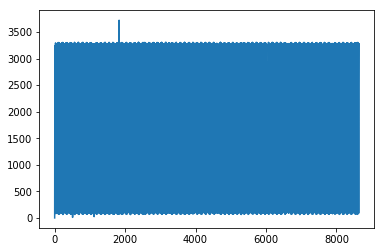

In [144]:
plt.plot(analogico_1)
plt.show()

In [51]:
print(len(data_list))
print(len(analogico_1))
print(data_list)

37276
33992
[b'\x00 \xf5\x13R', b'\x12\x1d\xf5\x11V', b'\x13\x0f\xf5\x0fF', b'\x11\x00\xf5\r$', b'\x11H\xf5\x0b\x01', b'\x0f\x15\xf5\x08k', b'\x0fR\xf5\x06b', b'\r\x10\xf5\x05\x04', b'\rM\xf5\x03>', b'\x0b\x1f\xf5\x02!', b'\x0b|\xf5\x01(', b'\tp\xf5\x00]', b'\nT\xf5\x00\x00', b'O\x08F\xf5\x01', b'\x18\tQ\xf5\x02', b'\t\x07~\xf5\x03', b'\x18\tO\xf5\x04', b'M\x084\xf5\x06', b'2\n\x05\xf5\x08', b'&\x08p\xf5\n', b'2\nn\xf5\x0c', b'K\n\x16\xf5\x0e', b'i\x0c2\xf5\x11', b'\x00\x0b_\xf5\x13', b'\x04\x0e.\xf5\x14', b'g\ro\xf5\x16', b'+\x106\xf5\x17', b'C\x0f[\xf5\x18', b';\x12\x19\xf5\x19', b'\x0e\x11\x1c\xf5\x19', b'G\x13.\xf5\x19', b'i\x12;\xf5\x19', b'?\x14 \xf5\x18', b'y\x12q\xf5\x18', b'\x1b\x143\xf5\x17', b'\x17\x12h\xf5\x15', b'p\x14\x10\xf5\x14', b'\x1d\x12\x1e\xf5\x12', b',\x13#\xf5\x10', b'\x1b\x11\x0f\xf5\x0e', b'\x02\x11v\xf5\x0b', b'b\x0fO\xf5\t', b'K\x10)\xf5\x07', b'<\re\xf5\x05', b'N\x0e-\xf5\x03', b'u\x0bw\xf5\x02', b'P\x0cK\xf5\x01', b'J\n(\xf5\x00', b'q\x0b\x02\xf5\x00', b'C\

In [105]:
for x,y,i in zip(data_list[1075:1200],analogico_1[1075:1200],range(len(analogico_1[1:]))):
    print(x,y,i)

In [16]:
for x in data_list[0]:
    print(x)

15
31
245
20
5


In [13]:
# VARIABLES para almacenar los valores de los sensores en el tiempo
digital_1 = []
digital_2 = []
analogico_1 = []
analogico_1.append(0)
analogico_2 = []
# Constantes de manipulacion para el main
flag_first_run = 0
flag_trama_len_cst = 0
list_pos_trama = []
i = 0
j = 0
#os.remove("Generator_data.txt")
file = open("Generator_data.txt","w")
file.write("0")
file.close()

In [14]:
flag_first_run = 0
for data_input in data_list[0:10]:
    #Codigo 
    flag_trama_len_cst = 0
    list_pos_trama = []
    enc_posi = data_input.find(245)
    # Chequeo de encabezado en la primera casilla
    if enc_posi==0:
        flag_first_run=0
    # Longitud de la trama
    trama_length = len(data_input)
    if trama_length!=5:
        continue
    posiciones = trama_length - enc_posi -1
    # Chequeo de encabezado en su ultima casilla
    if posiciones==0:
        flag_first_run=1
    # Entrando formato de la primera corrida
    if (flag_first_run==0):
        for pos in range(posiciones):
            list_pos_trama.append(enc_posi +pos+1)
        for pos_dato_trama in list_pos_trama:
            if (pos_dato_trama == enc_posi +1):
                digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                digital_1.append(digital_one)
                digital_2.append(digital_two)
                auxiliar = analogic_m_b
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi + 2):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_1.append(concatenation(auxiliar,analogic_l_b))
                print(analogico_1)
                flag_trama_len_cst += 1
                if enc_posi==2:
                    flag_trama_len_cst=0
                    flag_first_run=1
            elif (pos_dato_trama == enc_posi + 3):
                if enc_posi==1:
                    flag_trama_len_cst=0
                    flag_first_run=1
                    analogic_l_b = decode_channel12_two(data_input[0])
                    analogico_2.append(concatenation(auxiliar2,analogic_l_b))
                analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                auxiliar2 = analogic_m_b
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi + 4):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_2.append(concatenation(auxiliar2,analogic_l_b))
                flag_trama_len_cst += 1
            else:
                flag_first_run=1
                if (flag_trama_len_cst == 4):
                    flag_trama_len_cst = 0
                    flag_first_run=0
    else:
        posiciones = trama_length - enc_posi -1
        # Verificar que llegaron los dos canales completos
        for pos_dato_trama in range(enc_posi):
            if (pos_dato_trama == enc_posi -1):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_2.append(concatenation(auxiliar2,analogic_l_b))
                flag_trama_len_cst += 1
                if enc_posi==1:
                    # Agregando la posicion 3 antes de salir
                    digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[2])
                    digital_1.append(digital_one)
                    digital_2.append(digital_two)
                    auxiliar = analogic_m_b
                    # Agregando la ultima posicion antes de salir
                    analogic_l_b = decode_channel12_two(data_input[3])
                    analogico_1.append(concatenation(auxiliar,analogic_l_b))
                    analogic_m_b = decode_channel2_one(data_input[4])
                    auxiliar2 = analogic_m_b
                    flag_first_run=1
                if enc_posi==2:
                    # Agregando la posicion 3 antes de salir
                    digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[3])
                    digital_1.append(digital_one)
                    digital_2.append(digital_two)
                    auxiliar = analogic_m_b
                    # Agregando la ultima posicion antes de salir
                    analogic_l_b = decode_channel12_two(data_input[4])
                    analogico_1.append(concatenation(auxiliar,analogic_l_b))
                    flag_first_run=1
            elif (pos_dato_trama == enc_posi -2):
                analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                auxiliar2 = analogic_m_b
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi -3):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_1.append(concatenation(auxiliar,analogic_l_b))
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi -4):
                digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                digital_1.append(digital_one)
                digital_2.append(digital_two)
                auxiliar = analogic_m_b
                flag_trama_len_cst += 1
            else:
                flag_trama_len_cst = 0
                flag_first_run = 0

0000101
[0, 2565]
0111101
1101010
1001001
0011111
1001010
1010000
1010001
0000000
1001111
1101100
1000001
0111101
0011100
1111111
1111010
0100000
1000100
0101111


In [15]:
print(analogico_1)

[0, 2565, 2666, 2719, 2768, 2816, 2796, 2749, 2687, 2592, 2479]


In [44]:
print(data_list[1563])

b'\xf5\ne\x08"'


TypeError: Can't convert 'int' object to str implicitly